# Forecast

# Import module


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mordor_sd_assim import mordor_sd
import datetime
import litres
from save_tools import *
import properscoring as ps

#  Arrays definitions

In [2]:

""" Arrays sizes definition
npmt : number of parameters
ncond: number of initial conditions ? to verify
nres : number of results colomns in the final structure
tmax : number of dates pissibly simulated by Mordor
"""
npmt  = 100   
ncond = 72
nres  = 74 #230 
tmax  = 2000


#  Function to read file parameters

In [3]:

def res2pmt(data_file) :
    """Reader of parameters file for the Mordor model
    Input:
    -------
    - data_file: file name to read
    Output:
    -------
    - pmtdict: Dictionnary with parameters
      parameters names can be retrieved with 'names' key
    variables:
    -------
    pmt     : parameters arrays filled by the litres Fortran code
    pmtdict : dictionnay with all parameters
    name    : names of each parameters
    """
    pmt = np.zeros(npmt)
    
    litres.litres(nomfic=data_file, pmtmor=pmt)
    
    name = ["mod_neige","mod_deriv","mod_lac","mod_etp","mod_glace","mod_out","sbv","pdt","dh","fglace",
           "flac","xlat","z50","ztair","lonR","nstock","cp","cetp","csbv","gtz","gpz","etp1","etp2",
           "kmin","umax","lmax","zmax","evl","kr","lkn","evn","cel","dif","qcel","qdif","kf","kfp","efp",
           "eft","lts","gm","kg","kgp","efg","jg","ptjp1","raym","qext","zs1","fs1","fgi1","fgf1","zs2",
           "fs2","fgi2","fgf2","zs3","fs3","fgi3","fgf3","zs4","fs4","fgi4","fgf4","zs5","fs5","fgi5","fgf5",
           "zs6","fs6","fgi6","fgf6","zs7","fs7","fgi7","fgf7","zs8","fs8","fgi8","fgf8","zs9","fs9","fgi9",
           "fgf9","zs10","fs10","fgi10","fgf10","nsbv","qres","lqs","x92","x93","x94","x95","x96","x97","x98","x99","x100"]
    
    pmtdict={}
    
    for i in range(npmt):
        pmtdict[name[i]] = pmt[i]
    pmtdict['names'] = name
    return pmtdict


# Mordor calling function

In [4]:

def Calcul_MordorSD(Date, QS, NS, PS, TS, pmtdictn, cond=[np.nan]):
    """Driver for MORDOR simulation.
    Inputs:
    -------
    - Date: date objet
    - QS: observed flow rate, for comparison with the simulation
    - PS: precipitation (forcing)
    - TS: surface temperature (forcing)
    - pmtdict: model parameters, read from a parameter files of the type Param_Durance@Clapiere.res with function res2pmt
    Outputs:
    --------
    - dictionary with ("Date","Qobs","PS","T","Qam","rbase","rvers","rsurf", "S", "fneige",
      "U","L","Z","N","ep","er","Qmod","lg","agl")
      products names can be retrieved with the 'names' key
    variables:
    --------
    pmt  : parameters arrays filled by using the pmtdict dictionnary
    npdt : number of date to simulate
    JJ   : julian days computed from Date
    don  : an array with JJ,QS,PS,TS as input of the Mordor model
    res0 : output array
    init : integer (0 or 1) to initialise the Model set to 1
    cond         : array as input of the Mordor model, initial conditions ? to ask to EDF
    don_f, pmt_f, cond_f and res0_f: as respectively the arrays don, pmt, cond and res0
                   converted in arrays using Fortran-like index order
    RES          : dictionnary containing all products results
    RES['names'] : names on each product
  
    """

    pmt = np.zeros(npmt)
    for i_n in range(npmt):
        pmt[i_n] = pmtdict[pmtdict['names'][i_n]]
    
    npdt=len(Date)
    
    # julian days computation
    JJ = list()
    for id in Date: JJ.append(id.timetuple().tm_yday)
    
    don = np.zeros((tmax, 4))
    don[0:npdt,0] = np.asarray(JJ)
    don[0:npdt,1] = np.asarray(QS)
    don[0:npdt,2] = np.asarray(PS)
    don[0:npdt,3] = np.asarray(TS)

    res0 = np.zeros((tmax, nres))
    
    if cond[0]!=cond[0]: # no initialization 
        init = 0
        cond = np.zeros(ncond)+1
    else: #  initialization given
        init = 0

    cond[0] = npdt
    
    # creation of arrays using Fortran-like index order
    don_f  = np.array(don, dtype=np.float, order='F')
    pmt_f  = np.array(pmt, dtype=np.float, order='F')
    cond_f = np.array(cond, dtype=np.float, order='F')
    res0_f = np.array(res0, dtype=np.float, order='F')
    
    mordor_sd(don_f, pmt_f, cond_f, res0_f, init)
    

    # outputs data storage
    RES = {}
       # list of the names of each column in the outputs (in the same order as in the fortran)
    list_res   = ["Q", "fneige", "S", "N",
          "U_1", "U_2", "U_3", "U_4", "U_5", "U_6", "U_7", "U_8", "U_9", "U_10",
         "L_1", "L_2", "L_3", "L_4", "L_5", "L_6", "L_7", "L_8", "L_9", "L_10",
         "Z_1", "Z_2", "Z_3", "Z_4", "Z_5", "Z_6", "Z_7", "Z_8", "Z_9", "Z_10",
         "S_1", "S_2", "S_3", "S_4", "S_5", "S_6", "S_7", "S_8", "S_9", "S_10",
         "sns_1", "sns_2", "sns_3", "sns_4", "sns_5", "sns_6", "sns_7", "sns_8", "sns_9", "sns_10",
         "snl_1", "snl_2", "snl_3", "snl_4", "snl_5", "snl_6", "snl_7", "snl_8", "snl_9", "snl_10",
         "tst_1", "tst_2", "tst_3", "tst_4", "tst_5", "tst_6", "tst_7", "tst_8", "tst_9", "tst_10"]

    RES['names']  = list_res
    
    RES['Date']   = Date[0:npdt]
    RES['Qobs']   = np.asarray(QS[0:npdt])
    RES['Sobs']   = np.asarray(NS[0:npdt])
    RES['PS']     = np.asarray(PS[0:npdt])
    RES['T']      = np.asarray(TS[0:npdt])
    
    # filling the RES dictionary with each Mordor output
    for i_r in range(nres):
        RES[list_res[i_r]] = res0_f[0:npdt,i_r]


    return RES

# Function to create cond array (initial condition)

In [5]:
def make_cond_init(RES, npdt):
    """
    Function to create cond array (initial condition)
    Initial condition is made from last values (last date of simulation)
    of Mordor outputs
    -----
    Input:
    - RES: dictionary containing outputs from Mordor
    - nptd: nb of dates that will be simulated (can be 0 because
            this element is corrected juste before Mordor calling)
    Output:
    - cond: array containing Mordor initialization
    """
    
    # liste of each parameter need to be given in cond array
    list_cond_init = ["npdt", "N",\
         "U_1", "L_1", "Z_1", "S_1", "sns_1", "snl_1", "tst_1",\
         "U_2", "L_2", "Z_2", "S_2", "sns_2", "snl_2", "tst_2",\
         "U_3", "L_3", "Z_3", "S_3", "sns_3", "snl_3", "tst_3",\
         "U_4", "L_4", "Z_4", "S_4", "sns_4", "snl_4", "tst_4",\
         "U_5", "L_5", "Z_5", "S_5", "sns_5", "snl_5", "tst_5",\
         "U_6", "L_6", "Z_6", "S_6", "sns_6", "snl_6", "tst_6",\
         "U_7", "L_7", "Z_7", "S_7", "sns_7", "snl_7", "tst_7",\
         "U_8", "L_8", "Z_8", "S_8", "sns_8", "snl_8", "tst_8",\
         "U_9", "L_9", "Z_9", "S_9", "sns_9", "snl_9", "tst_9",\
         "U_10", "L_10", "Z_10", "S_10", "sns_10", "snl_10", "tst_10"]
    

    cond = np.zeros(ncond)
    # npdt corresponds to nb of dates in Mordor simulations,
    # it will be replaced just before Mordor calling
    cond[0] = npdt

    # cond filling
    for i_c in range(ncond):
        # skip first element (already stored)
        if i_c==0: continue
        # parameters are retrieved from RES dictionary (output of Mordor)
        # last value (last date of simulation) of each parameter is taken
        cond[i_c] = RES[list_cond_init[i_c]][-1]

    return cond


# Reading the Assimilation file

In [6]:
def lec_fichier_assim(infile):
    """
    Fonction lecture fichier Netcdf et calcul des CRPS et RMSE
    Inputs:
    -infile: fichier a lire
    Outputs:
    -Date: liste des dates (objet)
    -Q_obs: Q observe (fonction du temps)
    -Q_ens: Q simule (fonction du temps, pour chaque membre)
    -S_ens: S simulee (fonction du temps, pour chaque membre)
    """
       
    print('lecture ', infile)
    data_0 = lec_tabs(infile)

    cond = data_0['cond']
    
    return cond

In [26]:

"""
Initialization interface
- file_analyse : file containing initialisation
- d_ini_known  : beginning forcing date (format: YYYY-MM-DD)
- d_end_known  : end forcing date

Forecast interface
- d_end_fcst   : end unknown date
- d_first_old  : date of the old experiment
- n_old        : number of simulations
- year_step    : time step between each simulation (in year)

- data         : QPT values file name
- file_param   : parameters file name

Outputs save
- d_ini_save   : fisrt date to save
- save_file_n  : output fine name
"""
# year of the end of assimilation
year = 2017

# date of beginning of simulation
d_ini_known   = str(year-3) + "-09-01"
# date of the end of assimilation
d_end_known   = str(year)   + "-03-31"


# file with initial condition
save_file_n = "Assimilation_sans_FP_"+str(year)

###### forecast
# Nb of old years to use as unknown forcings
N_prev=50

#fisrt year of old forcings
first_year = 1968

# start and end dates of forcast
date_deb_fcst = "04-01"
date_fin_fcst = "08-31"

# NetCdf output file name
save_file_out = "fichier_sauv_previ_assimQ_"+str(year)




# Parameters and observations files

In [27]:

###
data       = "QPThisto_J_isere@bvi_coche_ponserand_valid.txt"
data2      = "SWE_NRC_NDAout.txt"
file_param = "isere_FINAL_J_SIM.res"#"FINAL_J_SIM.res"



In [28]:

# parameters reading
pmtdict = res2pmt(file_param)

# output mode of Mordor (specific to the wrapper)
pmtdict["mod_out"] = 3

#####################################################################
#####################################################################

#d_fin = datetime.datetime.strptime(d_end_fcst, '%Y-%m-%d')
d_end_fcst = d_end_known[:4] + "-" + date_fin_fcst

d_fin = datetime.datetime.strptime(d_end_fcst, '%Y-%m-%d')
d_ikn = datetime.datetime.strptime(d_ini_known, '%Y-%m-%d')
d_ekn = datetime.datetime.strptime(d_end_known, '%Y-%m-%d')



###
Qobs   = list()
PSo    = list()
TSo    = list()
date_l = list()

#fmt   = '%d/%m/%Y' #'01/01/1948'

# observations file reading
QPT = open(data)
il=0
i_dt = 0
for iline in QPT:
    tmp_line = iline.split()
    il += 1
    if il==1: continue
    dt = datetime.datetime.strptime(tmp_line[0][1:11], '%d/%m/%Y')
    if (dt > d_fin): continue
    i_dt += 1
    #  we note the beginning and end of the period given
    if (dt == d_ikn): index_ikn = i_dt -1
    if (dt == d_ekn): index_ekn = i_dt -1
    date_l.append(dt)
    Qobs.append(float(tmp_line[1]))
    PSo.append(float(tmp_line[2]))
    TSo.append(float(tmp_line[3]))

QPT.close()

In [29]:

###
Sobs   = list()
date_l2 = list()

#fmt   = '%d/%m/%Y' #'01/01/1948'

# observations file reading, NRC
QPT2 = open(data2)
il=0
i_dt = 0
for iline in QPT2:
    tmp_line = iline.split()
    il += 1
    if il==1: continue
    dt = datetime.datetime.strptime(tmp_line[0][1:11], '%d/%m/%Y')
    if (dt > d_fin): continue
    i_dt += 1
    if (dt == d_ikn): index_ikn2 = i_dt -1
    if (dt == d_ekn): index_ekn2 = i_dt -1
    date_l2.append(dt)
    Sobs.append(float(tmp_line[1]))

QPT2.close()

In [30]:
list_res = list()
# loop on each old forcings
for i_ete in range(N_prev):
    d_debut_previ = datetime.datetime.strptime(str(first_year + i_ete)+"-"+date_deb_fcst, '%Y-%m-%d')
    d_fin_previ = datetime.datetime.strptime(str(first_year + i_ete)+"-"+date_fin_fcst, '%Y-%m-%d')
    print("prevision "+str(first_year + i_ete))
        # search for start and end indexes corresponding to these dates
    indice_deb = np.where(np.asarray(date_l)==d_debut_previ)[0][0]
    indice_fin = np.where(np.asarray(date_l)==d_fin_previ)[0][0]
    
    #  Mordor input array
    date_ete = date_l[indice_deb:indice_fin+1]
    Qobs_ete= Qobs[indice_deb:indice_fin+1]
    Sobs_ete= Sobs[index_ekn2+1:]
    
    PS_ete= PSo[indice_deb:indice_fin+1]
    TS_ete= TSo[indice_deb:indice_fin+1]
    
    npdt = len(date_ete)
    
    infile = save_file_n + ".nc"
    cond_ete = np.mean(lec_fichier_assim(infile), axis=1)
    
    res = Calcul_MordorSD(date_ete, Qobs_ete, Sobs_ete, PS_ete, TS_ete, pmtdict, cond=cond_ete)
    list_res.append(res)

prevision 1968
('lecture ', 'Assimilation_sans_FP_2017.nc')
prevision 1969
('lecture ', 'Assimilation_sans_FP_2017.nc')
prevision 1970
('lecture ', 'Assimilation_sans_FP_2017.nc')
prevision 1971
('lecture ', 'Assimilation_sans_FP_2017.nc')
prevision 1972
('lecture ', 'Assimilation_sans_FP_2017.nc')
prevision 1973
('lecture ', 'Assimilation_sans_FP_2017.nc')
prevision 1974
('lecture ', 'Assimilation_sans_FP_2017.nc')
prevision 1975
('lecture ', 'Assimilation_sans_FP_2017.nc')
prevision 1976
('lecture ', 'Assimilation_sans_FP_2017.nc')
prevision 1977
('lecture ', 'Assimilation_sans_FP_2017.nc')
prevision 1978
('lecture ', 'Assimilation_sans_FP_2017.nc')
prevision 1979
('lecture ', 'Assimilation_sans_FP_2017.nc')
prevision 1980
('lecture ', 'Assimilation_sans_FP_2017.nc')
prevision 1981
('lecture ', 'Assimilation_sans_FP_2017.nc')
prevision 1982
('lecture ', 'Assimilation_sans_FP_2017.nc')
prevision 1983
('lecture ', 'Assimilation_sans_FP_2017.nc')
prevision 1984
('lecture ', 'Assimilatio

In [31]:
#nb of dates in forecast
np_date_ens = len(list_res[0]['Q'])
# table creation
Q_ens   = np.zeros([np_date_ens, N_prev])
S_ens   = np.zeros([np_date_ens, N_prev])
S_n_ens = np.zeros((np_date_ens, 10, N_prev))

for i_ete in range(N_prev):
    Q_ens[:, i_ete]      = list_res[i_ete]['Q'][:]
    S_ens[:, i_ete]      = list_res[i_ete]['S'][:]
    S_n_ens[:, 0, i_ete] = list_res[i_ete]['S_1'][:]
    S_n_ens[:, 1, i_ete] = list_res[i_ete]['S_2'][:]
    S_n_ens[:, 2, i_ete] = list_res[i_ete]['S_3'][:]
    S_n_ens[:, 3, i_ete] = list_res[i_ete]['S_4'][:]
    S_n_ens[:, 4, i_ete] = list_res[i_ete]['S_5'][:]
    S_n_ens[:, 5, i_ete] = list_res[i_ete]['S_6'][:]
    S_n_ens[:, 6, i_ete] = list_res[i_ete]['S_7'][:]
    S_n_ens[:, 7, i_ete] = list_res[i_ete]['S_8'][:]
    S_n_ens[:, 8, i_ete] = list_res[i_ete]['S_9'][:]
    S_n_ens[:, 9, i_ete] = list_res[i_ete]['S_10'][:]


    print('Saving outputs...')

Saving outputs...
Saving outputs...
Saving outputs...
Saving outputs...
Saving outputs...
Saving outputs...
Saving outputs...
Saving outputs...
Saving outputs...
Saving outputs...
Saving outputs...
Saving outputs...
Saving outputs...
Saving outputs...
Saving outputs...
Saving outputs...
Saving outputs...
Saving outputs...
Saving outputs...
Saving outputs...
Saving outputs...
Saving outputs...
Saving outputs...
Saving outputs...
Saving outputs...
Saving outputs...
Saving outputs...
Saving outputs...
Saving outputs...
Saving outputs...
Saving outputs...
Saving outputs...
Saving outputs...
Saving outputs...
Saving outputs...
Saving outputs...
Saving outputs...
Saving outputs...
Saving outputs...
Saving outputs...
Saving outputs...
Saving outputs...
Saving outputs...
Saving outputs...
Saving outputs...
Saving outputs...
Saving outputs...
Saving outputs...
Saving outputs...
Saving outputs...


In [32]:
# preparation of the tables to be recorded
DATE       = np.zeros((5, np_date_ens)) #YYYY, mm, dd, HH, MM
for i_t in range(npdt):
    DATE[0, i_t] = list_res[0]['Date'][i_t].year
    DATE[1, i_t] = list_res[0]['Date'][i_t].month
    DATE[2, i_t] = list_res[0]['Date'][i_t].day
    DATE[3, i_t] = list_res[0]['Date'][i_t].hour
    DATE[4, i_t] = list_res[0]['Date'][i_t].minute

data_out = {}
data_out['Qobs_hiver']      = Qobs[index_ikn:index_ekn+1]
data_out['Sobs_hiver']      = Sobs[index_ikn2:index_ekn2+1]
data_out['Qobs_ete']      = Qobs_ete[:]
data_out['Sobs_ete']      = Sobs_ete[:]
data_out['S_1_ens']    = S_n_ens[:, 0, :]
data_out['S_2_ens']    = S_n_ens[:, 1, :]
data_out['S_3_ens']    = S_n_ens[:, 2, :]
data_out['S_4_ens']    = S_n_ens[:, 3, :]
data_out['S_5_ens']    = S_n_ens[:, 4, :]
data_out['S_6_ens']    = S_n_ens[:, 5, :]
data_out['S_7_ens']    = S_n_ens[:, 6, :]
data_out['S_8_ens']    = S_n_ens[:, 7, :]
data_out['S_9_ens']    = S_n_ens[:, 8, :]
data_out['S_10_ens']   = S_n_ens[:, 9, :]
data_out['Q_ens']      = Q_ens[:, :]
data_out['S_ens']      = S_ens[:, :]
data_out['DATE']       = DATE[:,:]
# stored the dictionary in NetCdf file

save_file_out_v = save_file_out + ".nc"
rec_tabs(data_out, save_file_out_v)

In [33]:
dates_previ = list()
for i_d in range(np_date_ens):
    dates_previ.append(d_ekn + datetime.timedelta(days=(1 + i_d)))


# Plot

In [36]:
d_ini_plot = str(year) + "-04-01"

d_plt = datetime.datetime.strptime(d_ini_plot, '%Y-%m-%d')

ind_deb_plot = np.where(np.asarray(date_l)==d_plt)[0][0]

# filtre sur -9999 dans Qobs
Qobs_hiver = np.asarray(Qobs[index_ikn:index_ekn+1])
Sobs_hiver = np.asarray(Sobs[index_ikn2:index_ekn2+1])
Qobs_ete   = np.asarray(Qobs_ete)
Sobs_ete   = np.asarray(Sobs_ete)

Qobs_hiver[np.where(np.abs(Qobs_hiver) > 1000.)] = np.nan
Sobs_hiver[np.where(np.abs(Sobs_hiver) > 1000.)] = np.nan
Qobs_ete[np.where(np.abs(Qobs_ete) > 1000.)] = np.nan
Sobs_ete[np.where(np.abs(Sobs_ete) > 1000.)] = np.nan


/home/farouki/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in greater
  app.launch_new_instance()


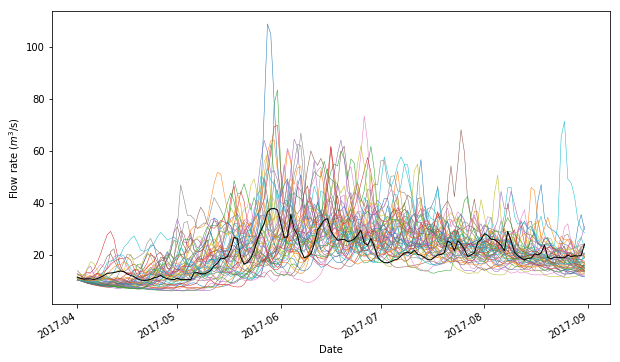

In [37]:
fig = plt.figure(1, figsize=(10, 6))

# Q simulated in winter
#plt.plot(date_l[index_ikn:index_ekn+1], RES_hiver['Q'][:index_ekn+1], '-b', label='Winter flow rate', linewidth=1.)

# Q simulated in summer
for i_e in range(N_prev):
    if i_e==0:
        plt.plot(dates_previ, Q_ens[:, i_e], label="Forcage %i"%(first_year+i_e), linewidth=0.5)
    else:
        plt.plot(dates_previ, Q_ens[:, i_e],  label="Forcage %i"%(first_year+i_e),linewidth=0.5)

#plt.plot(date_l[index_ikn:index_ekn+1], Qobs_hiver[:index_ekn+1],'k',  label="Observed flow rate")
plt.plot(dates_previ, Qobs_ete[:],'-k', label='Observed flow rate', linewidth=1)

plt.xlabel("Date")
plt.ylabel('Flow rate ($m^3$/s)')
#plt.ylabel('S (mm)')

plt.gcf().autofmt_xdate()
#plt.legend()
plt.show()


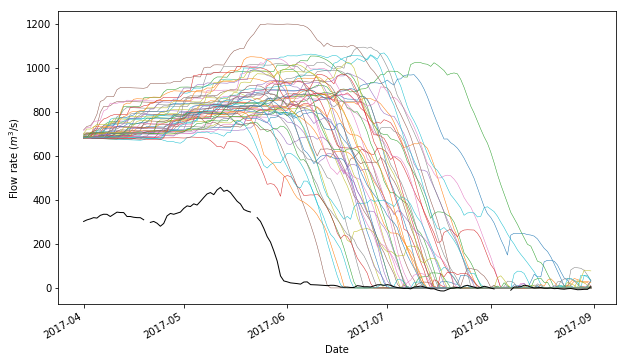

In [39]:
fig = plt.figure(1, figsize=(10, 6))

# S simulated in winter
#plt.plot(date_l[index_ikn:index_ekn+1], RES_hiver['S'][:index_ekn+1], '-b', label='Winter flow rate', linewidth=1.)

# S simulated in summer
for i_e in range(N_prev):
    if i_e==0:
        plt.plot(dates_previ, S_n_ens[:,8, i_e], label="Forcage %i"%(first_year+i_e), linewidth=0.5)
    else:
        plt.plot(dates_previ, S_n_ens[:,8, i_e], label="Forcage %i"%(first_year+i_e), linewidth=0.5)

#plt.plot(date_l[index_ikn:index_ekn+1], Sobs_hiver[:index_ekn+1],'k',  label="Observed flow rate")
plt.plot(dates_previ, Sobs_ete[:],'k',label='Observed Snow', linewidth=1)

plt.xlabel("Date")
plt.ylabel('Flow rate ($m^3$/s)')
#plt.ylabel('S (mm)')

plt.gcf().autofmt_xdate()
#plt.legend()
plt.show()
